<a href="https://colab.research.google.com/github/saverin0/llms_workshops_files/blob/main/oxford_llm_workshop_5_Transformers_interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture
# First, uninstall all conflicting packages
!pip uninstall -y numpy transformers torch torchvision torchaudio bertviz captum sentencepiece

# Install NumPy first
!pip install numpy

# Then install PyTorch
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

# Finally install the other packages
!pip install transformers==4.46.1 bertviz==1.4.0 captum==0.8.0 sentencepiece==0.2.1

# IMPORTANT: Restart the runtime after this

## 1. Transformers interpretability

Transformer models as other deep learning models are considered not totally interpretable. This is an open research question and there is no no out of the box solution.

However, there are approaches to partially understand how model makes desicion and to what extent a particular input feature (token in case of NLP) corresponds to predicted output.

We will look up into attention visualusation methods as well as salience methods (like Integrated Gradients) to see how it works and to what extent is useful.






### 1.1 Attenton visualisation

Attention is the man mechanism that makes transformes models so powerful. We can visualuse attention weights and explore what tokens have higher attention and how tokens attend to each other.

We will use ```bertviz``` library. Despite the fact that library has 'bert' in its name, it can be applied for various models.

In [1]:
import pkg_resources
import transformers

print(f"numpy: {pkg_resources.get_distribution('numpy').version}")
print(f"transformers: {transformers.__version__}")
print(f"bertviz: {pkg_resources.get_distribution('bertviz').version}")
print(f"captum: {pkg_resources.get_distribution('captum').version}")

/tmp/ipython-input-1733823485.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


numpy: 1.26.4
transformers: 4.46.1
bertviz: 1.4.0
captum: 0.8.0


In [2]:
from transformers import AutoTokenizer, AutoModel, utils
from bertviz import model_view, head_view
import torch

utils.logging.set_verbosity_error()

model_name = "bert-base-uncased"
model = AutoModel.from_pretrained(model_name, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [3]:
input_text = "The cat sat on the mat"

inputs = tokenizer.encode(input_text, return_tensors="pt")  # Tokenize input text
outputs = model(inputs)  # Run model

In [4]:
outputs.keys()

odict_keys(['last_hidden_state', 'pooler_output', 'attentions'])

In [5]:
len(outputs.attentions), outputs.attentions[0].shape

(12, torch.Size([1, 12, 8, 8]))

In [6]:
attention = outputs.attentions

In [7]:
tokens = tokenizer.convert_ids_to_tokens(inputs[0])
tokens

['[CLS]', 'the', 'cat', 'sat', 'on', 'the', 'mat', '[SEP]']

In [8]:
head_view(attention, tokens)

<IPython.core.display.Javascript object>

In [9]:
model_view(attention, tokens)

<IPython.core.display.Javascript object>

In [10]:
%%capture
!pip install sacremosses

In [11]:
# Initialize tokenizer and model. Be sure to set output_attentions=True.
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, utils

model_name = "Helsinki-NLP/opus-mt-en-de"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name, output_attentions=True)

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

source.spm:   0%|          | 0.00/768k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/797k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/298M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/generation/configuration_utils.py:774: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(


generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [12]:
# Encode input

encoder_input_ids = tokenizer(
    "She sees the small elephant.", return_tensors="pt", add_special_tokens=True
).input_ids

In [13]:
# obtain output (translated text)

decoder_input_ids = model.generate(encoder_input_ids)

In [14]:
# we see that translation makes sense

tokenizer.decode(decoder_input_ids[0], skip_special_tokens=True)

'Sie sieht den kleinen Elefanten.'

In [15]:
encoder_text = tokenizer.convert_ids_to_tokens(encoder_input_ids[0])
decoder_text = tokenizer.convert_ids_to_tokens(decoder_input_ids[0])

In [16]:
outputs = model(input_ids=encoder_input_ids, decoder_input_ids=decoder_input_ids)

In [17]:
# we see we have what we need among keys

outputs.keys()

odict_keys(['logits', 'past_key_values', 'decoder_attentions', 'cross_attentions', 'encoder_last_hidden_state', 'encoder_attentions'])

In [18]:
head_view(
    encoder_attention=outputs.encoder_attentions,
    decoder_attention=outputs.decoder_attentions,
    cross_attention=outputs.cross_attentions,
    encoder_tokens=encoder_text,
    decoder_tokens=decoder_text,
)

<IPython.core.display.Javascript object>

In [19]:
model_view(
    encoder_attention=outputs.encoder_attentions,
    decoder_attention=outputs.decoder_attentions,
    cross_attention=outputs.cross_attentions,
    encoder_tokens=encoder_text,
    decoder_tokens=decoder_text,
)

<IPython.core.display.Javascript object>

## 1.2 Saliency methods

Previosly we looked up at how to analyse general model properties (e.g. how model distributes its attention while processing input sentences). While that may be useful and provides good insights into how model undertsnands text, this information is abstract and has no relation to specific data.

Very ofthen there is a need to analyse model behaviour with respect to secific data samples. In other words given input data and model prediction we want to undertstand how each of the input tokenc contributed into final prediction.

Consider example of sentiment analysis problem.
Given input text ```text = 'I liked thos movie very much. It has good actors as well as the story line was great.'``` our model predicts that the sentiment of this sentence is positive. But we would like to know what tokens contributed most into model prediction.


In [20]:
model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"

In [22]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

model = AutoModelForSequenceClassification.from_pretrained(model_path)
if torch.cuda.is_available():
    model.cuda()

# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [26]:
from captum.attr import IntegratedGradients

In [27]:
def custom_forward(x):
    return torch.log_softmax(model(inputs_embeds=x).logits, -1)


ig = IntegratedGradients(custom_forward)

In [28]:
text = "I liked thos movie very much. It has good actors as well as the story line was great."

batch = tokenizer(text, return_tensors="pt").to(model.device)

actual_embeddings = model.roberta.embeddings(input_ids=batch.input_ids)
reference_embeddings = actual_embeddings * 0  # a vector of zeros

In [29]:
out = model(inputs_embeds=actual_embeddings)

In [30]:
out

SequenceClassifierOutput(loss=None, logits=tensor([[-1.2388, -0.4755,  1.7170]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [31]:
torch.softmax(out.logits, -1)

tensor([[0.0447, 0.0959, 0.8593]], grad_fn=<SoftmaxBackward0>)

In [32]:
import pandas as pd

results = pd.DataFrame(
    {
        "tok": tokenizer.convert_ids_to_tokens(batch.input_ids[0]),
        "neg": ig.attribute(actual_embeddings, reference_embeddings, target=0)[0]
        .sum(axis=1)
        .detach()
        .cpu()
        .numpy(),
        "pos": ig.attribute(actual_embeddings, reference_embeddings, target=2)[0]
        .sum(axis=1)
        .detach()
        .cpu()
        .numpy(),
    }
)

In [33]:
results

,tok,neg,pos
0,<s>,-0.182035,-0.102616
1,▁I,-0.010445,0.038076
2,▁like,0.023919,0.044212
3,d,-0.033588,0.044719
4,▁tho,-0.012125,0.030979
5,s,-0.005570,0.032663
6,▁movie,-0.179978,0.076685
7,▁very,0.046224,0.004398
8,▁much,0.036638,0.014143
9,.,-0.069105,0.106231


In [37]:
import matplotlib.pyplot as plt
import numpy as np

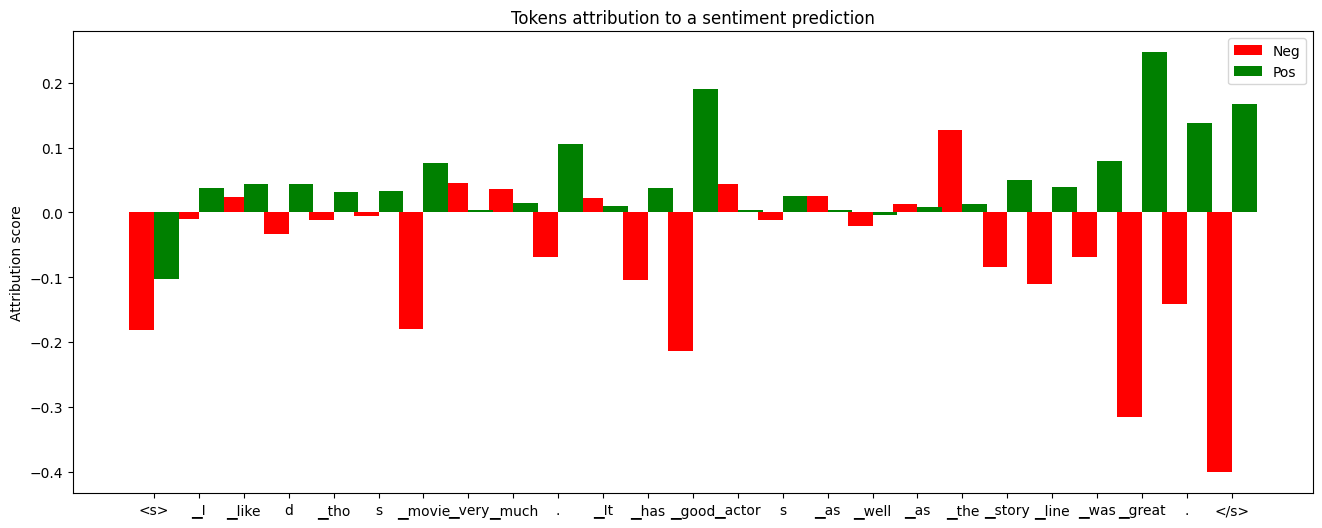

In [38]:
fig, ax = plt.subplots(figsize=(16, 6))

labels = results["tok"]
x = np.arange(len(labels))  # the label locations
width = 0.55  # the width of the bars

rects1 = ax.bar(x - width / 2, results["neg"], width, label="Neg", color="r")
rects2 = ax.bar(x + width / 2, results["pos"], width, label="Pos", color="g")


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Attribution score")
ax.set_title("Tokens attribution to a sentiment prediction")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()